# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/pull_requests_total_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


Using INTRO_DATE from mapping file: 


# Generate Commit Metrics per Repository

## Amount of Commits over time

In [4]:
pr_result = []
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    pr_file = f"{repository}/pull_requests.csv"
    # Check if the file exists
    if not os.path.exists(pr_file) or os.stat(pr_file).st_size == 1:
        print(f"File not found or empty: {pr_file}. Skipping repository.")
        continue
    pr_df = pd.read_csv(pr_file)
    print(pr_df['created_at'].max())
    print(len(pr_df))
    pr_df = truncate_to_same_length(pr_df, INTRO_DATE, 'created_at', 'defined', START_DATE, END_DATE)
    print(len(pr_df))
    print(pr_df.columns)
    pr_df = aggregate_by_date(pr_df, 'created_at', 'time_until_merged', 'sum')

    print(pr_df['created_at'].max())
    
    pre_release, post_release = split_by_date(pr_df, INTRO_DATE, 'created_at')

    pre_release_buckets = generate_value_in_buckets(pre_release, 'created_at', 'count', 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'created_at', 'count', 'sum', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['count'].to_dict())  # Use 'count' instead of 'value'
    
    pr_result.append(result_row)

# Create the DataFrame
pr_result_df = pd.DataFrame(pr_result)


2025-03-20T09:40:49.065000
223
201
Index(['merge_id', 'sha', 'author', 'merged_by', 'merged_at', 'state',
       'created_at', 'updated_at', 'closed_at', 'title', 'description',
       'requested_reviewers', 'labels', 'assignees', 'time_until_closed',
       'time_until_merged'],
      dtype='object')
2025-02-14
2025-03-18T14:56:18.683000
977
422
Index(['merge_id', 'sha', 'author', 'merged_by', 'merged_at', 'state',
       'created_at', 'updated_at', 'closed_at', 'title', 'description',
       'requested_reviewers', 'labels', 'assignees', 'time_until_closed',
       'time_until_merged'],
      dtype='object')
2025-02-14
2025-03-19T12:26:38.737000
168
95
Index(['merge_id', 'sha', 'author', 'merged_by', 'merged_at', 'state',
       'created_at', 'updated_at', 'closed_at', 'title', 'description',
       'requested_reviewers', 'labels', 'assignees', 'time_until_closed',
       'time_until_merged'],
      dtype='object')
2025-02-14
2025-03-19T12:26:38.737000
520
235
Index(['merge_id', 'sha'

/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66679/1216709875.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(pr_result_df, 'pre-', 'post-')
pr_result_df = pr_result_df[columns_order]

In [6]:
pr_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,11.0,9.0,22.0,24.0,14.0,10.0,14.0,7.0,12.0,13.0,8.0,14.0,9.0,8.0,NaN,5.0,9.0,12.0
1,P9,24.0,53.0,43.0,26.0,28.0,16.0,31.0,1.0,21.0,47.0,3.0,32.0,9.0,9.0,11.0,38.0,9.0,21.0
2,P2,4.0,NaN,7.0,3.0,3.0,6.0,NaN,8.0,NaN,6.0,5.0,9.0,7.0,9.0,1.0,10.0,6.0,11.0
3,P8,29.0,26.0,18.0,11.0,13.0,26.0,5.0,10.0,24.0,10.0,8.0,3.0,7.0,3.0,NaN,8.0,14.0,20.0
4,P1,20.0,17.0,29.0,17.0,24.0,27.0,13.0,27.0,10.0,11.0,12.0,8.0,15.0,1.0,4.0,5.0,19.0,16.0
5,k1bu0cscd4,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,50.0,28.0,32.0,10.0,23.0,33.0,13.0,23.0,25.0,21.0,8.0,22.0,18.0,9.0,8.0,28.0,19.0,7.0
7,P7,32.0,40.0,28.0,28.0,23.0,8.0,23.0,13.0,NaN,19.0,12.0,20.0,20.0,14.0,NaN,14.0,17.0,32.0
8,P5,7.0,3.0,4.0,NaN,14.0,12.0,NaN,NaN,NaN,13.0,19.0,10.0,11.0,3.0,NaN,8.0,6.0,8.0
9,P14,34.0,25.0,34.0,5.0,30.0,51.0,16.0,20.0,10.0,29.0,22.0,12.0,3.0,22.0,14.0,22.0,17.0,30.0


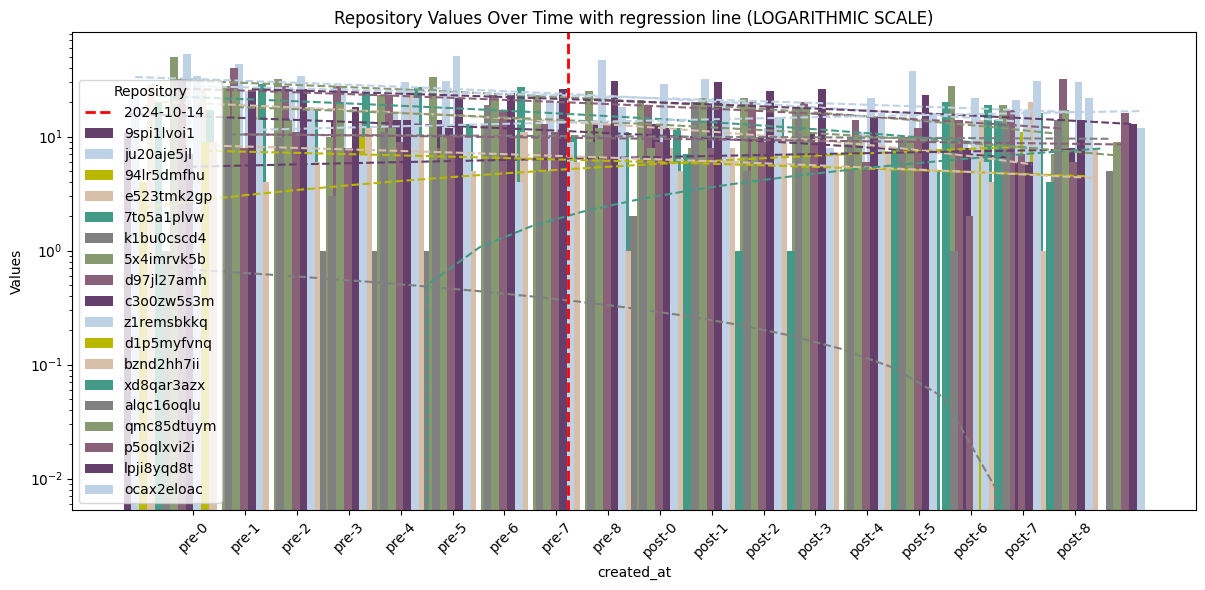

In [7]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in pr_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(pr_result_df['repository']):
    # Extract data for the current repository
    values = pr_result_df[pr_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = pr_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(pr_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

# Significancetest 

In [8]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the pr_result_df
pr_result_df = pr_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in pr_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in pr_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(pr_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository  pre_p_value  after_p_value  pre_normal  after_normal
0   P3     0.157600   4.683659e-01        True          True
1   P9     0.908710   1.253236e-01        True          True
2   P2     0.228883   5.764447e-01        True          True
3   P8     0.390673   6.554797e-01        True          True
4   P1     0.550753   8.888360e-01        True          True
5   k1bu0cscd4     0.000419   3.217493e-07       False         False
6   5x4imrvk5b     0.593414   1.572909e-01        True          True
7   P7     0.813049   4.418019e-01        True          True
8   P5     0.032668   9.753060e-01       False          True
9   P14     0.918006   6.492258e-01        True          True
10  P6     0.120648   3.972153e-01        True          True
11  bznd2hh7ii     0.771627   4.426845e-01        True          True
12  xd8qar3azx     1.000000   8.252790e-02        True          True
13  P4     0.557941   8.559022e-01        True          True
14  P13     0.661728   3.466081e-01        T

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, pr_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(pr_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta    -0.493827 -0.888889  0.024691
1   P9  Cliff's Delta    -0.271605 -0.803086  0.321296
2   P2  Cliff's Delta     0.617284  0.160494  0.938272
3   P8  Cliff's Delta    -0.666667 -0.950617 -0.234568
4   P1  Cliff's Delta    -0.753086 -1.000000 -0.308642
5   k1bu0cscd4  Cliff's Delta    -0.283951 -0.666667  0.135802
6   5x4imrvk5b  Cliff's Delta    -0.666667 -1.000000 -0.209877
7   P7  Cliff's Delta    -0.308642 -0.827160  0.284259
8   P5  Cliff's Delta     0.419753 -0.098765  0.851852
9   P14  Cliff's Delta    -0.271605 -0.765432  0.284259
10  P6  Cliff's Delta    -0.234568 -0.741049  0.358642
11  bznd2hh7ii  Cliff's Delta    -0.234568 -0.703704  0.395062
12  xd8qar3azx  Cliff's Delta     0.777778  0.444444  1.000000
13  P4  Cliff's Delta     0.111111 -0.419753  0.654321
14  P13  Cliff's Delta    -0.283951 -0.753086  0.296605
15  P12  Cliff's Delta    -0.456790 -0.864815  0.111111
16  P10  Cliff's Delta

In [10]:
merged = pr_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,11.0,9.0,22.0,24.0,14.0,10.0,14.0,7.0,12.0,...,9.0,8.0,0.0,5.0,9.0,12.0,Cliff's Delta,-0.493827,-0.888889,0.024691
1,P9,24.0,53.0,43.0,26.0,28.0,16.0,31.0,1.0,21.0,...,9.0,9.0,11.0,38.0,9.0,21.0,Cliff's Delta,-0.271605,-0.803086,0.321296
2,P2,4.0,0.0,7.0,3.0,3.0,6.0,0.0,8.0,0.0,...,7.0,9.0,1.0,10.0,6.0,11.0,Cliff's Delta,0.617284,0.160494,0.938272
3,P8,29.0,26.0,18.0,11.0,13.0,26.0,5.0,10.0,24.0,...,7.0,3.0,0.0,8.0,14.0,20.0,Cliff's Delta,-0.666667,-0.950617,-0.234568
4,P1,20.0,17.0,29.0,17.0,24.0,27.0,13.0,27.0,10.0,...,15.0,1.0,4.0,5.0,19.0,16.0,Cliff's Delta,-0.753086,-1.000000,-0.308642
5,k1bu0cscd4,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.283951,-0.666667,0.135802
6,5x4imrvk5b,50.0,28.0,32.0,10.0,23.0,33.0,13.0,23.0,25.0,...,18.0,9.0,8.0,28.0,19.0,7.0,Cliff's Delta,-0.666667,-1.000000,-0.209877
7,P7,32.0,40.0,28.0,28.0,23.0,8.0,23.0,13.0,0.0,...,20.0,14.0,0.0,14.0,17.0,32.0,Cliff's Delta,-0.308642,-0.827160,0.284259
8,P5,7.0,3.0,4.0,0.0,14.0,12.0,0.0,0.0,0.0,...,11.0,3.0,0.0,8.0,6.0,8.0,Cliff's Delta,0.419753,-0.098765,0.851852
9,P14,34.0,25.0,34.0,5.0,30.0,51.0,16.0,20.0,10.0,...,3.0,22.0,14.0,22.0,17.0,30.0,Cliff's Delta,-0.271605,-0.765432,0.284259


In [11]:
merged = pr_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,11.0,9.0,22.0,24.0,14.0,10.0,14.0,7.0,12.0,...,9.0,8.0,0.0,5.0,9.0,12.0,Cliff's Delta,-0.493827,-0.888889,0.024691
1,P9,24.0,53.0,43.0,26.0,28.0,16.0,31.0,1.0,21.0,...,9.0,9.0,11.0,38.0,9.0,21.0,Cliff's Delta,-0.271605,-0.803086,0.321296
2,P2,4.0,0.0,7.0,3.0,3.0,6.0,0.0,8.0,0.0,...,7.0,9.0,1.0,10.0,6.0,11.0,Cliff's Delta,0.617284,0.160494,0.938272
3,P8,29.0,26.0,18.0,11.0,13.0,26.0,5.0,10.0,24.0,...,7.0,3.0,0.0,8.0,14.0,20.0,Cliff's Delta,-0.666667,-0.950617,-0.234568
4,P1,20.0,17.0,29.0,17.0,24.0,27.0,13.0,27.0,10.0,...,15.0,1.0,4.0,5.0,19.0,16.0,Cliff's Delta,-0.753086,-1.000000,-0.308642
5,k1bu0cscd4,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.283951,-0.666667,0.135802
6,5x4imrvk5b,50.0,28.0,32.0,10.0,23.0,33.0,13.0,23.0,25.0,...,18.0,9.0,8.0,28.0,19.0,7.0,Cliff's Delta,-0.666667,-1.000000,-0.209877
7,P7,32.0,40.0,28.0,28.0,23.0,8.0,23.0,13.0,0.0,...,20.0,14.0,0.0,14.0,17.0,32.0,Cliff's Delta,-0.308642,-0.827160,0.284259
8,P5,7.0,3.0,4.0,0.0,14.0,12.0,0.0,0.0,0.0,...,11.0,3.0,0.0,8.0,6.0,8.0,Cliff's Delta,0.419753,-0.098765,0.851852
9,P14,34.0,25.0,34.0,5.0,30.0,51.0,16.0,20.0,10.0,...,3.0,22.0,14.0,22.0,17.0,30.0,Cliff's Delta,-0.271605,-0.765432,0.284259


# Interpretation
- 0 -> less commits after introduction
- 1, 4,5 -> more commits after introduction